# VLNCE+EnvDrop AUG
VLNCE 301355

EnvDrop ?? 

In [1]:
import gc
import os,sys
os.chdir("/root/EvoEnc/")
import random
import warnings
from collections import defaultdict
from datetime import datetime
os.environ["MAGNUM_LOG"] = "quiet"
os.environ["HABITAT_SIM_LOG"] = "quiet"
import numpy as np
from PIL import Image
import copy
import torch
from pathlib import Path
from tqdm.notebook import tqdm
from habitat import logger
from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.common.environments import get_env_class
from habitat_baselines.common.obs_transformers import (
    apply_obs_transforms_batch,
    apply_obs_transforms_obs_space,
    get_active_obs_transforms,
)
from habitat_baselines.common.tensorboard_utils import TensorboardWriter
from habitat_baselines.utils.common import batch_obs

from evoenc.common.aux_losses import AuxLosses
from evoenc.common.base_il_trainer import BaseVLNCETrainer
from evoenc.common.env_utils import construct_envs
from evoenc.common.utils import extract_instruction_tokens
from evoenc.config.default import get_config
def _pause_envs(
    envs_to_pause,
    envs,
    not_done_masks,
    prev_actions,
    batch,
    rgb_frames=None,
):
    # pausing envs with no new episode
    if len(envs_to_pause) > 0:
        state_index = list(range(envs.num_envs))
        for idx in reversed(envs_to_pause):
            state_index.pop(idx)
            envs.pause_at(idx)

        # indexing along the batch dimensions
        not_done_masks = not_done_masks[state_index]
        prev_actions = prev_actions[state_index]

        for k, v in batch.items():
            batch[k] = v[state_index]

        if rgb_frames is not None:
            rgb_frames = [rgb_frames[i] for i in state_index]

    return (
        envs,
        not_done_masks,
        prev_actions,
        batch,
        rgb_frames,
    )

/root/habitat-lab21/habitat/utils/visualizations/maps.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  AGENT_SPRITE = imageio.imread(
/root/miniconda3/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
2024-03-04 17:25:08.751930: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-04 17:25:09.109003: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use 

## VLN-CE train

In [2]:
CONFIG = "/root/EvoEnc/evoenc/config/old/evoenc.yaml"
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage3/rgb-vlnce/train")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage3/depth-vlnce/train")
FOLDER_INST_OUT = Path("/root/autodl-tmp/stage3/text-vlnce/train")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/stage3/sub-vlnce/train")

os.makedirs(FOLDER_RGB_OUT, exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT, exist_ok=True)
os.makedirs(FOLDER_INST_OUT, exist_ok=True)
os.makedirs(FOLDER_SUB_OUT, exist_ok=True)
total_cnt = 0

device = torch.device("cuda")
config = get_config(CONFIG)
envs = construct_envs(config, get_env_class(config.ENV_NAME))
expert_uuid = config.IL.DAGGER.expert_policy_sensor_uuid
prev_actions = torch.zeros(
    envs.num_envs,
    1,
    device=device,
    dtype=torch.long,
)
not_done_masks = torch.zeros(
    envs.num_envs, 1, dtype=torch.bool, device=device
)

observations = envs.reset()
observations_raw = copy.deepcopy(observations)
observations = extract_instruction_tokens(
    observations, config.TASK_CONFIG.TASK.INSTRUCTION_SENSOR_UUID
)
batch = batch_obs(observations, device)
obs_transforms = get_active_obs_transforms(config)
batch = apply_obs_transforms_batch(batch, obs_transforms)

episodes = [[] for _ in range(envs.num_envs)]
skips = [False for _ in range(envs.num_envs)]
# Populate dones with False initially
dones = [False for _ in range(envs.num_envs)]

collected_eps = 0
ep_ids_collected = None
ensure_unique_episodes = True
if ensure_unique_episodes:
    ep_ids_collected = {
        ep.episode_id for ep in envs.current_episodes()
    }
RGB_SIZE = 224
DEPTH_SIZE = 224
LEN = 256
PAD_IDX = 1
SUB_PAD_IDX = 1
SUB_LEN = 50
SUB_NUM = 12
DOWNSAMPLE = 2
with tqdm(total=config.IL.DAGGER.update_size, dynamic_ncols=True) as pbar:
    while collected_eps < config.IL.DAGGER.update_size:
        current_episodes = None
        envs_to_pause = None
        if ensure_unique_episodes:
            envs_to_pause = []
            current_episodes = envs.current_episodes()

        for i in range(envs.num_envs):
            if dones[i] and not skips[i]:
                ep = episodes[i]
                N = len(ep)
                for step in range(0, N, DOWNSAMPLE):
                    rgb = ep[step][0]["rgb"]
                    depth = ep[step][0]["depth"][..., 0]
                    text = ep[step][0]["instruction"]["text"]
                    sub = ep[step][0]["sub_instruction"]["text"]

                    rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(total_cnt)
                    depth_path = FOLDER_DEPTH_OUT / "{}.png".format(total_cnt)
                    inst_path = FOLDER_INST_OUT / "{}.txt".format(total_cnt)
                    sub_path = FOLDER_SUB_OUT / "{}.txt".format(total_cnt)

                    rgb = Image.fromarray(rgb)
                    depth = (depth*10.0*1000).astype(np.uint16) # to meters, and scale 1000 times
                    depth = Image.fromarray(depth)
                    depth = depth.resize((DEPTH_SIZE, DEPTH_SIZE))

                    rgb.save(rgb_path)
                    depth.save(depth_path)
                    with open(inst_path, "w") as f:
                        f.write(text)
                    with open(sub_path, "w") as f:
                        f.write("\n".join(sub))

                    total_cnt+=1
                    

                pbar.update()
                collected_eps += 1

                if ensure_unique_episodes:
                    if (
                        current_episodes[i].episode_id
                        in ep_ids_collected
                    ):
                        envs_to_pause.append(i)
                    else:
                        ep_ids_collected.add(
                            current_episodes[i].episode_id
                        )
            if dones[i]:
                episodes[i] = []

        if ensure_unique_episodes:
            (
                envs,
                not_done_masks,
                prev_actions,
                batch,
                _,
            ) = _pause_envs(
                envs_to_pause,
                envs,
                not_done_masks,
                prev_actions,
                batch,
            )
            if envs.num_envs == 0:
                break

        actions = batch[expert_uuid].long()

        for i in range(envs.num_envs):
            episodes[i].append(
                (
                    observations_raw[i],
                    prev_actions[i].item(),
                    batch[expert_uuid][i].item(),
                )
            )

        skips = batch[expert_uuid].long() == -1
        actions = torch.where(
            skips, torch.zeros_like(actions), actions
        )
        skips = skips.squeeze(-1)  # .to(device="cpu")
        prev_actions.copy_(actions)

        outputs = envs.step([a[0].item() for a in actions])
        observations, _, dones, _ = [list(x) for x in zip(*outputs)]
        observations_raw = copy.deepcopy(observations)
        observations = extract_instruction_tokens(
            observations,
            config.TASK_CONFIG.TASK.INSTRUCTION_SENSOR_UUID,
        )
        batch = batch_obs(observations, device)
        batch = apply_obs_transforms_batch(batch, obs_transforms)

        not_done_masks = torch.tensor(
            [[0] if done else [1] for done in dones],
            dtype=torch.uint8,
            device=device,
        )


envs.close()
envs = None


2024-03-04 13:43:54,930 Initializing dataset VLN-CE-v1


/root/habitat-lab21/habitat/utils/visualizations/maps.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  AGENT_SPRITE = imageio.imread(
/root/habitat-lab21/habitat/utils/visualizations/maps.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  AGENT_SPRITE = imageio.imread(
/root/habitat-lab21/habitat/utils/visualizations/maps.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  AG

  0%|          | 0/10819 [00:00<?, ?it/s]

I0304 13:52:44.775940 846532 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I0304 13:52:44.776114 846532 SemanticScene.h:43] Deconstructing SemanticScene
I0304 13:52:44.781785 846532 SceneManager.h:25] Deconstructing SceneManager
I0304 13:52:44.781814 846532 SceneGraph.h:25] Deconstructing SceneGraph
I0304 13:52:44.783077 846532 Sensor.cpp:69] Deconstructing Sensor
I0304 13:52:44.783202 846532 Sensor.cpp:69] Deconstructing Sensor
I0304 13:52:44.826248 846532 Renderer.cpp:71] Deconstructing Renderer
I0304 13:52:44.826294 846532 WindowlessContext.h:17] Deconstructing WindowlessContext
I0304 13:52:44.834394 846532 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5s.glb and dataset : default which is currently active dataset.
I0304 13:52:44.843572 846532 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : data/scene_datasets/mp3d/r47D5H71a5s/r47D5H71a5

301355


301355
/root/autodl-tmp/stage3/rgb-vlnce/train/19008.jpg /root/autodl-tmp/stage3/depth-vlnce/train/19008.png


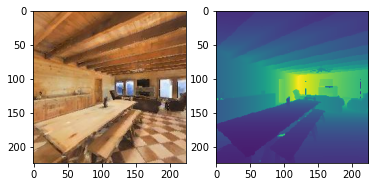

9025
/root/autodl-tmp/stage3/rgb-vlnce/train/142360.jpg /root/autodl-tmp/stage3/depth-vlnce/train/142360.png


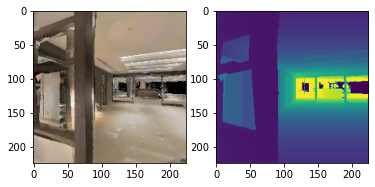

10000
/root/autodl-tmp/stage3/rgb-vlnce/train/290321.jpg /root/autodl-tmp/stage3/depth-vlnce/train/290321.png


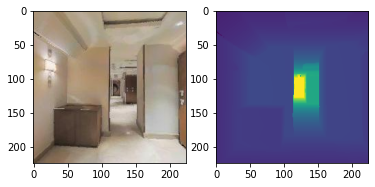

10000
/root/autodl-tmp/stage3/rgb-vlnce/train/141336.jpg /root/autodl-tmp/stage3/depth-vlnce/train/141336.png


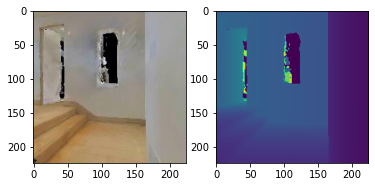

7088
/root/autodl-tmp/stage3/rgb-vlnce/train/93887.jpg /root/autodl-tmp/stage3/depth-vlnce/train/93887.png


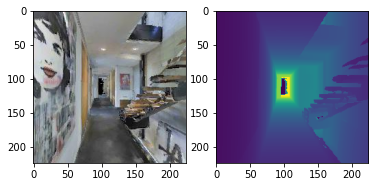

10000
/root/autodl-tmp/stage3/rgb-vlnce/train/268584.jpg /root/autodl-tmp/stage3/depth-vlnce/train/268584.png


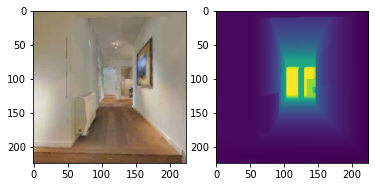

8298
/root/autodl-tmp/stage3/rgb-vlnce/train/296270.jpg /root/autodl-tmp/stage3/depth-vlnce/train/296270.png


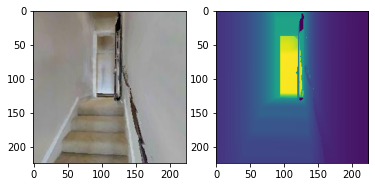

4941
/root/autodl-tmp/stage3/rgb-vlnce/train/86229.jpg /root/autodl-tmp/stage3/depth-vlnce/train/86229.png


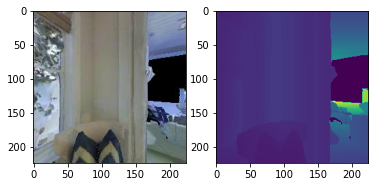

7107
/root/autodl-tmp/stage3/rgb-vlnce/train/95698.jpg /root/autodl-tmp/stage3/depth-vlnce/train/95698.png


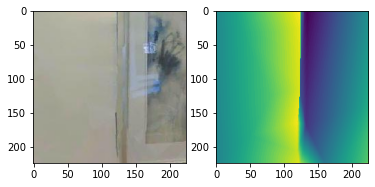

527
/root/autodl-tmp/stage3/rgb-vlnce/train/219416.jpg /root/autodl-tmp/stage3/depth-vlnce/train/219416.png


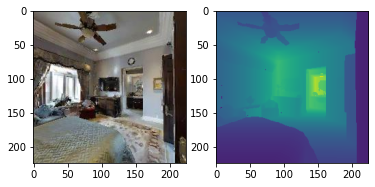

7599
301355
==========172650==========
inst: Turn around to your left and move forward into the hallway. Walk through the double doors, move forward and wait on the striped rug. 
sub: Turn around to your left
and move forward into the hallway
Walk through the double doors
move forward
and wait on the striped rug
==========227477==========
inst: Turn around and walk past the barber chair. Then turn left and walk forward toward the plants.  Turn left and walk into the next room and stand next to the chair. 
sub: Turn around
and walk past the barber chair
Then turn left
and walk forward toward the plants
Turn left
and walk into the next room
and stand next to the chair
==========148538==========
inst: Walk through the library along the long wooden table. Walk out of the door on the other end of the room underneath the stairwell. Walk into the hallway passed the statue and stop on the stairwell do the lower level. 
sub: Walk through the library along the long wooden table
Walk out of the d

In [4]:
print(total_cnt)
import matplotlib.pyplot as plt
# vision train
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage3/")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage3/")
rgb_files = sorted(list(FOLDER_RGB_OUT.glob("rgb-*/train/*.jpg")))
depth_files = sorted(list(FOLDER_DEPTH_OUT.glob("depth-*/train/*.png")))
print(len(rgb_files))
assert len(rgb_files)==len(depth_files)
for _ in range(10):
    idx = random.randint(0, len(rgb_files)-1)
    rgb = Image.open(rgb_files[idx])
    depth = Image.open(depth_files[idx])
    print(rgb_files[idx], depth_files[idx])
    plt.figure()
    plt.subplot(1,2, 1)
    plt.imshow(rgb)
    plt.subplot(1,2, 2)
    plt.imshow(np.array(depth).astype(float))
    plt.show()
    print(np.array(depth).max())
# text train
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage3/")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage3/")
text_files = sorted(list(FOLDER_RGB_OUT.glob("text-*/train/*.txt")))
sub_files = sorted(list(FOLDER_DEPTH_OUT.glob("sub-*/train/*.txt")))
assert len(text_files)==len(sub_files)
print(len(text_files))
for _ in range(10):
    idx = random.randint(0, len(text_files)-1)
    print("=========={}==========".format(idx))
    with open(text_files[idx], "r") as f:
        print("inst: "+f.read())
    with open(sub_files[idx], "r") as f:
        print("sub: "+f.read())

## AUG

In [2]:
CONFIG = "/root/EvoEnc/evoenc/config/old/evoenc_aug.yaml"
FOLDER_RGB_OUT = Path("/root/autodl-tmp/stage3/rgb-envdrop/train")
FOLDER_DEPTH_OUT = Path("/root/autodl-tmp/stage3/depth-envdrop/train")
FOLDER_INST_OUT = Path("/root/autodl-tmp/stage3/text-envdrop/train")
FOLDER_SUB_OUT = Path("/root/autodl-tmp/stage3/sub-envdrop/train")

os.makedirs(FOLDER_RGB_OUT, exist_ok=True)
os.makedirs(FOLDER_DEPTH_OUT, exist_ok=True)
os.makedirs(FOLDER_INST_OUT, exist_ok=True)
os.makedirs(FOLDER_SUB_OUT, exist_ok=True)
total_cnt = 0

device = torch.device("cuda")
config = get_config(CONFIG)
envs = construct_envs(config, get_env_class(config.ENV_NAME))
expert_uuid = config.IL.DAGGER.expert_policy_sensor_uuid
prev_actions = torch.zeros(
    envs.num_envs,
    1,
    device=device,
    dtype=torch.long,
)
not_done_masks = torch.zeros(
    envs.num_envs, 1, dtype=torch.bool, device=device
)

observations = envs.reset()
observations_raw = copy.deepcopy(observations)
observations = extract_instruction_tokens(
    observations, config.TASK_CONFIG.TASK.INSTRUCTION_SENSOR_UUID
)
batch = batch_obs(observations, device)
obs_transforms = get_active_obs_transforms(config)
batch = apply_obs_transforms_batch(batch, obs_transforms)

episodes = [[] for _ in range(envs.num_envs)]
skips = [False for _ in range(envs.num_envs)]
# Populate dones with False initially
dones = [False for _ in range(envs.num_envs)]

collected_eps = 0
ep_ids_collected = None
ensure_unique_episodes = True
if ensure_unique_episodes:
    ep_ids_collected = {
        ep.episode_id for ep in envs.current_episodes()
    }
RGB_SIZE = 224
DEPTH_SIZE = 224
LEN = 256
PAD_IDX = 1
SUB_PAD_IDX = 1
SUB_LEN = 50
SUB_NUM = 12
DOWNSAMPLE = 3
with tqdm(total=config.IL.DAGGER.update_size, dynamic_ncols=True) as pbar:
    while collected_eps < config.IL.DAGGER.update_size:
        current_episodes = None
        envs_to_pause = None
        if ensure_unique_episodes:
            envs_to_pause = []
            current_episodes = envs.current_episodes()

        for i in range(envs.num_envs):
            if dones[i] and not skips[i]:
                ep = episodes[i]
                N = len(ep)
                for step in range(0, N, DOWNSAMPLE):
                    rgb = ep[step][0]["rgb"]
                    depth = ep[step][0]["depth"][..., 0]
                    text = ep[step][0]["instruction"]["text"]
                    sub = ep[step][0]["sub_instruction"]["text"]

                    rgb_path = FOLDER_RGB_OUT / "{}.jpg".format(total_cnt)
                    depth_path = FOLDER_DEPTH_OUT / "{}.png".format(total_cnt)
                    inst_path = FOLDER_INST_OUT / ("%08d.txt"%(total_cnt))
                    sub_path = FOLDER_SUB_OUT / ("%08d.txt"%(total_cnt))

                    rgb = Image.fromarray(rgb)
                    depth = (depth*10.0*1000).astype(np.uint16) # to meters, and scale 1000 times
                    depth = Image.fromarray(depth)
                    depth = depth.resize((DEPTH_SIZE, DEPTH_SIZE))

                    rgb.save(rgb_path)
                    depth.save(depth_path)
                    with open(inst_path, "w") as f:
                        f.write(text)
                    with open(sub_path, "w") as f:
                        f.write("\n".join(sub))

                    total_cnt+=1
                    

                pbar.update()
                collected_eps += 1

                if ensure_unique_episodes:
                    if (
                        current_episodes[i].episode_id
                        in ep_ids_collected
                    ):
                        envs_to_pause.append(i)
                    else:
                        ep_ids_collected.add(
                            current_episodes[i].episode_id
                        )
            if dones[i]:
                episodes[i] = []

        if ensure_unique_episodes:
            (
                envs,
                not_done_masks,
                prev_actions,
                batch,
                _,
            ) = _pause_envs(
                envs_to_pause,
                envs,
                not_done_masks,
                prev_actions,
                batch,
            )
            if envs.num_envs == 0:
                break

        actions = batch[expert_uuid].long()

        for i in range(envs.num_envs):
            episodes[i].append(
                (
                    observations_raw[i],
                    prev_actions[i].item(),
                    batch[expert_uuid][i].item(),
                )
            )

        skips = batch[expert_uuid].long() == -1
        actions = torch.where(
            skips, torch.zeros_like(actions), actions
        )
        skips = skips.squeeze(-1)  # .to(device="cpu")
        prev_actions.copy_(actions)

        outputs = envs.step([a[0].item() for a in actions])
        observations, _, dones, _ = [list(x) for x in zip(*outputs)]
        observations_raw = copy.deepcopy(observations)
        observations = extract_instruction_tokens(
            observations,
            config.TASK_CONFIG.TASK.INSTRUCTION_SENSOR_UUID,
        )
        batch = batch_obs(observations, device)
        batch = apply_obs_transforms_batch(batch, obs_transforms)

        not_done_masks = torch.tensor(
            [[0] if done else [1] for done in dones],
            dtype=torch.uint8,
            device=device,
        )

envs.close()
envs = None


2024-03-04 17:25:16,670 Initializing dataset VLN-CE-v1


/root/habitat-lab21/habitat/utils/visualizations/maps.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  AGENT_SPRITE = imageio.imread(
/root/habitat-lab21/habitat/utils/visualizations/maps.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  AGENT_SPRITE = imageio.imread(
/root/habitat-lab21/habitat/utils/visualizations/maps.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  AG

  0%|          | 0/157232 [00:00<?, ?it/s]

I0304 17:35:52.646414 83034 PhysicsManager.cpp:50] Deconstructing PhysicsManager
I0304 17:35:52.646624 83034 SemanticScene.h:43] Deconstructing SemanticScene
I0304 17:35:52.652340 83034 SceneManager.h:25] Deconstructing SceneManager
I0304 17:35:52.652364 83034 SceneGraph.h:25] Deconstructing SceneGraph
I0304 17:35:52.653249 83034 Sensor.cpp:69] Deconstructing Sensor
I0304 17:35:52.653335 83034 Sensor.cpp:69] Deconstructing Sensor
I0304 17:35:52.656015 83034 Renderer.cpp:71] Deconstructing Renderer
I0304 17:35:52.656033 83034 WindowlessContext.h:17] Deconstructing WindowlessContext
I0304 17:35:52.659971 83034 MetadataMediator.cpp:68] ::setSimulatorConfiguration : Set new simulator config for scene/stage : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb and dataset : default which is currently active dataset.
I0304 17:35:52.666162 83034 ManagedFileBasedContainer.h:210] <Scene Instance>::convertFilenameToPassedExt : Filename : data/scene_datasets/mp3d/sKLMLpTHeUy/sKLMLpTHeUy.glb chan

EOFError: 

In [ ]:
import gzip
import json
with gzip.open("/root/MLA/data/datasets/R2R_VLNCE_NRSub_T/joint_train_envdrop/joint_train_envdrop_sub.json.gz", "r") as f:
    aug_data = json.loads(f.read())

In [ ]:
with h5py.File('/hy-tmp/stage2/data.mat','r') as t:
    print(t["rgb"].shape)